<a href="https://colab.research.google.com/github/amerycong/intel_inhouse_rankings/blob/main/inhouse_rankings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

README:

Before running (you can run all), here's what you have to change:

1) make sure you have access to the inhouse_game_data shared folder and your gdrive is mounted

2) api_key: might need to refresh a new riot api key

3) make sure guest_list is populated with any non-intel players

4) make any updates to PLAYER_ROLE_PREF as desired

5) make sure tournament_code is the code used in the previous inhouse game, and ign is the summoner name of someone that played in that game

6) run all -> share outputs as desired, use matchmaking tool for next game. don't forget to use battlefy or something to generate new tourney code



# Code

In [11]:
# RESET AFTER MATCH BELOW 

#code for last played match
tournament_code = 'NA04a98-f64fcde7-dfe2-4315-9515-89b3e4e701d4'
#ign of someone who played in that game
ign = "ghostfishkiller"

#secret key
api_key = ''

In [12]:
try:
    import trueskill
except:
    %pip install trueskill
    import trueskill
try:
    from cassiopeia import Summoner
    import cassiopeia as cass
except:
    %pip install cassiopeia
    from cassiopeia import Summoner
    import cassiopeia as cass
import numpy as np
import pandas as pd
import random
import itertools
import bisect
import os
import json
import ipywidgets as widgets
import IPython
import requests
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from google.colab import drive
drive.mount('/content/drive')

cass.set_riot_api_key(api_key)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
version = requests.get('https://ddragon.leagueoflegends.com/api/versions.json').json()[0]
champs = requests.get('https://ddragon.leagueoflegends.com/cdn/{}/data/en_US/champion.json'.format(version)).json()
CHAMP_ICON_URL = 'https://ddragon.leagueoflegends.com/cdn/{}/img/champion/{{}}.png'.format(version)
champs_by_key = {int(champ['key']): champ for champ in champs['data'].values()}

In [14]:
SMURFS = {
    'King Cong': 'TensorFlow',
    'SlantyEyes': 'TensorFlow',
    'Vladahri': 'Ahrizona',
    'IAS Viper': 'Miss Viper',
    'loli egirl UwUxo': 'TensorFlow',
    'ohHawlo': 'import antigrvty',
    'PaoIa': 'GaI Gadot',
    'Harbay': 'Harbayyy',
    'Mr Morde': 'TheGatorMan',
    'dont add': 'azsplice'
}

def get_canonical_name(name):
    return SMURFS[name] if name in SMURFS else name

def parser(raw):
  if 'metadata' in json.loads(raw).keys():
    return parse_match(raw)
  else:
    return parse_old_match(raw)

def parse_match(raw):
    match = json.loads(raw)
    
    match_id = match["info"]["gameId"]    
    match_duration = match["info"]["gameDuration"]
    identities = {
        pid["participantId"]: {"summonerName": pid["summonerName"]} for pid in match['info']['participants']
    }

    win_team, loss_team = (
        next(team["teamId"] for team in match["info"]["teams"] if team["win"] == result)
        for result in (True, False)
    )

    win, loss = (
        tuple(
            get_canonical_name(identities[p["participantId"]]["summonerName"])
            for p in match['info']['participants']
            if p["teamId"] == team
        )
        for team in (win_team, loss_team)
    )
    
    match_bans = [champs_by_key[x['championId']]['id'] for x in match["info"]["teams"][0]["bans"]+match["info"]["teams"][1]["bans"]]
    player_stats = {
        get_canonical_name(identities[p["participantId"]]["summonerName"]): {
              'win': p["win"],
              'kills': p["kills"],
              'deaths': p["deaths"],
              'assists': p["assists"],
              'role': p['role'],
              'lane': p['lane'],
              'cs_minion': p["totalMinionsKilled"],
              'cs_neutral': p["neutralMinionsKilled"],
              'vision': p["visionScore"],
              'gold': p["goldEarned"],
              'total_dmg_champs': p['totalDamageDealtToChampions'],
              #'cs_diff_10': p["timeline"]['csDiffPerMinDeltas']['0-10']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '0-10' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #this shit bugged, not in all games
              #'cs_diff_20': p["timeline"]['csDiffPerMinDeltas']['0-10']*10+p["timeline"]['csDiffPerMinDeltas']['10-20']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '10-20' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #cs diff unreliable for 20+30, ignores monsters
              #'cs_diff_30': p["timeline"]['csDiffPerMinDeltas']['0-10']*10+p["timeline"]['csDiffPerMinDeltas']['10-20']*10+p["timeline"]['csDiffPerMinDeltas']['20-30']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '20-30' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #cs diff unreliable for 20+30, ignores monsters
              'champ': champs_by_key[p['championId']]['id'],
              'match_duration': match_duration
        }
        for p in match['info']['participants']
    }

    return pd.Series({
        'match_id': match_id,
        'win': win,
        'loss': loss,
        'bans': match_bans,
        'player_stats': player_stats,
    })

def parse_old_match(raw):
    match = json.loads(raw)
    
    match_id = match["gameId"]    
    match_duration = match["gameDuration"]
    identities = {
        pid["participantId"]: pid["player"] for pid in match["participantIdentities"]
    }

    win_team, loss_team = (
        next(team["teamId"] for team in match["teams"] if team["win"] == result)
        for result in ("Win", "Fail")
    )

    win, loss = (
        tuple(
            get_canonical_name(identities[p["participantId"]]["summonerName"])
            for p in match["participants"]
            if p["teamId"] == team
        )
        for team in (win_team, loss_team)
    )
    
    match_bans = [champs_by_key[x['championId']]['id'] for x in match["teams"][0]["bans"]+match["teams"][1]["bans"]]
    player_stats = {
        get_canonical_name(identities[p["participantId"]]["summonerName"]): {
              'win': p["stats"]["win"],
              'kills': p["stats"]["kills"],
              'deaths': p["stats"]["deaths"],
              'assists': p["stats"]["assists"],
              'role': p['timeline']['role'],
              'lane': p['timeline']['lane'],
              'cs_minion': p["stats"]["totalMinionsKilled"],
              'cs_neutral': p["stats"]["neutralMinionsKilled"],
              'vision': p["stats"]["visionScore"],
              'gold': p["stats"]["goldEarned"],
              'total_dmg_champs': p["stats"]['totalDamageDealtToChampions'],
              'cs_diff_10': p["timeline"]['csDiffPerMinDeltas']['0-10']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '0-10' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #this shit bugged, not in all games
              'cs_diff_20': p["timeline"]['csDiffPerMinDeltas']['0-10']*10+p["timeline"]['csDiffPerMinDeltas']['10-20']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '10-20' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #cs diff unreliable for 20+30, ignores monsters
              'cs_diff_30': p["timeline"]['csDiffPerMinDeltas']['0-10']*10+p["timeline"]['csDiffPerMinDeltas']['10-20']*10+p["timeline"]['csDiffPerMinDeltas']['20-30']*10 if 'csDiffPerMinDeltas' in p["timeline"].keys() and '20-30' in p["timeline"]['csDiffPerMinDeltas'].keys() else 0, #cs diff unreliable for 20+30, ignores monsters
              'champ': champs_by_key[p['championId']]['id'],
              'match_duration': match_duration
        }
        for p in match["participants"]
    }
    if False:
      #stats with shitters
      b= 'ANiceSunset'
      a= 'Ahrizona'
      if a in player_stats.keys() and b in player_stats.keys():
        if (a in win and b in win) or (a in loss and b in loss):
          player_stats[a+' ('+b+')']=player_stats.pop(a)
          win = tuple([x.replace(a,a+' ('+b+')') for x in list(win)])
          loss = tuple([x.replace(a,a+' ('+b+')') for x in list(loss)])

    if False:
      #jg only stats (shit junglers)
      for n in ['TensorFlow']:
        if n in player_stats.keys():
          if player_stats[n]['lane']=='JUNGLE':
            player_stats[n+' (jungle)']=player_stats.pop(n)
            win = tuple([x.replace(n,n+' (jungle)') for x in list(win)])
            loss = tuple([x.replace(n,n+' (jungle)') for x in list(loss)])
    if True:
      #lane only stats (jg in lane lul)
      for n in ['MrRgrs', 'ZoSo']:       
        if n in player_stats.keys():
          if player_stats[n]['lane']!='JUNGLE':
            player_stats[n+' (lane)']=player_stats.pop(n)
            win = tuple([x.replace(n,n+' (lane)') for x in list(win)])
            loss = tuple([x.replace(n,n+' (lane)') for x in list(loss)])
    if False:
      #adc only stats 
      for n in ['ANiceSunset','Ahrizona','Kurtzorz']:       
        if n in player_stats.keys():
          if (player_stats[n]['role']!='DUO_SUPPORT') and (player_stats[n]['lane']=='BOTTOM'):
            player_stats[n+' (adc)']=player_stats.pop(n)
            win = tuple([x.replace(n,n+' (adc)') for x in list(win)])
            loss = tuple([x.replace(n,n+' (adc)') for x in list(loss)])

    return pd.Series({
        'match_id': match_id,
        'win': win,
        'loss': loss,
        'bans': match_bans,
        'player_stats': player_stats,
    })


def compute_division_boundaries():
    divisions = [
        "{} {}".format(tier, division)
        for tier in [
            "8086",
            "Pentium",
            "Celeron",
            "Core i3",
            "Core i5",
            "Core i7",
            "Core i9",
            "Xeon",
        ]
        for division in ["IV", "III", "II", "I"]
    ]
    division_boundaries = [(float("-inf"), divisions[0])]
    min_rating = trueskill.global_env().mu - 3 * trueskill.global_env().sigma
    max_rating = trueskill.global_env().mu + 3 * trueskill.global_env().sigma
    division_boundaries.extend(
        (
            min_rating + i * (max_rating - min_rating) / (len(divisions) - 1),
            divisions[i + 1],
        )
        for i in range(len(divisions) - 1)
    )
    return division_boundaries


def find_division(boundaries, rating):
    chally = False
    prev_cutoff = boundaries[bisect.bisect(boundaries, (rating, "")) - 1][0]
    try:
      next_cutoff = boundaries[bisect.bisect(boundaries, (rating, ""))][0]
    except:
      chally = True
    if prev_cutoff == -np.inf:
      lp_diff = boundaries[2][0]-boundaries[1][0]
      lp = int(round(100-(next_cutoff-rating)/lp_diff*100))
    elif chally:
      lp_diff = boundaries[-1][0]-boundaries[-2][0]
      lp = int(round((rating-prev_cutoff)/lp_diff*100))
    else:
      lp = int(round((rating-prev_cutoff)/(next_cutoff-prev_cutoff)*100))
    return boundaries[bisect.bisect(boundaries, (rating, "")) - 1][1]+' '+str(lp)+' LP'

def compute_record(stats):
    win = sum(1 for game in stats if game and game["win"])
    loss = sum(1 for game in stats if game and not game["win"])
    return "{:.0%} ({}W {}L)".format(win / (win + loss), win, loss)


def compute_streak(stats):
    last_result = None
    count = 0
    for game in stats[::-1]:
        if game is not None:
            if last_result is None:
                last_result = game["win"]
            if game["win"] == last_result:
                count += 1
            else:
                break
    return "{}{}".format(count, "W" if last_result else "L")

def compute_kda(stats,string=True):
    num_games = sum(1 for game in stats if game)
    kills = sum(game['kills'] for game in stats if game) / num_games
    deaths = sum(game['deaths'] for game in stats if game) / num_games
    assists = sum(game['assists'] for game in stats if game) / num_games
    kda =  (kills + assists) / max(1,deaths)
    if string:
      return "{:.1f} / {:.1f} / {:.1f} ({:.1f})".format(kills, deaths, assists, kda)
    else:
      return kda
  
def compute_gametime(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game)
    num_games = sum(1 for game in stats if game)
    gametime = total_game_duration / num_games
    return "{:.2f}".format(gametime)

def compute_cspm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game if game['role'] not in ['DUO_SUPPORT'])#not (game['role'] in ['DUO_SUPPORT'] and game['lane'] in ['BOTTOM']))
    if total_game_duration == 0:
      return "-1"
    cspm = sum(game['cs_minion']+game['cs_neutral'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_game_duration#not (game['role'] in ['DUO_SUPPORT'] and game['lane'] in ['BOTTOM'])) / total_game_duration
    return "{:.1f}".format(cspm)

def compute_visionpm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game)# if game['role'] not in ['DUO_SUPPORT'])
    #num_games = sum(1 for game in stats if game)
    if total_game_duration == 0:
      return "-1"
    #vision_score = sum(game['vision'] for game in stats if game) / num_games
    visionpm = sum(game['vision'] for game in stats if game) / total_game_duration
    return "{:.2f}".format(visionpm)

def compute_dmgpm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game if game['role'] not in ['DUO_SUPPORT'])
    if total_game_duration == 0:
      return "-1"
    dmg = sum(game['total_dmg_champs'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_game_duration
    return "{:.0f}".format(dmg)

def compute_dmgpg(stats):
    total_gold = sum(game['gold'] for game in stats if game if game['role'] not in ['DUO_SUPPORT'])
    if total_gold == 0:
      return "-1"
    dmg = sum(game['total_dmg_champs'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_gold
    return "{:.2f}".format(dmg)

def compute_gpm(stats):
    total_game_duration = sum(game['match_duration']/60.0 for game in stats if game if game['role'] not in ['DUO_SUPPORT'])
    if total_game_duration == 0:
      return "-1"
    gpm = sum(game['gold'] for game in stats if game if game['role'] not in ['DUO_SUPPORT']) / total_game_duration
    return "{:.0f}".format(gpm)

def compute_csdiff(stats,time=10):
    #time = 10,20,30
    num_games = sum(1 for game in stats if game if 'cs_diff_'+str(time) in game.keys() if game['role'] not in ['DUO_SUPPORT'] if game['lane'] not in ['JUNGLE'])
    if num_games == 0:
      return "-1"
    csdiff = sum(game['cs_diff_'+str(time)] for game in stats if game if 'cs_diff_'+str(time) in game.keys() if game['role'] not in ['DUO_SUPPORT'] if game['lane'] not in ['JUNGLE']) / num_games
    return "{:.1f}".format(csdiff)

def compute_dick_length(stats):
    total_num_champs = len(champs['data'])
    num_games = sum(1 for game in stats if game)
    num_unique_champs = len(set([game["champ"] for game in stats if game]))
    if num_unique_champs == total_num_champs:
      dick_length = 12
    else:
      bde = num_unique_champs / num_games
      avg_pp_size = 3.61
      min_games = 30 #negative activeness if under this amount of games played
      avg_champ_pool = 15 #benchmark for pos/neg pool size influence
      avg_bde = 0.5 #benchmark for champ variety (0.5 = 1 new champ every 2 games)
      gamma = 0.3 #scaling for pool multiplier
      champ_pool_multiplier = (num_unique_champs/avg_champ_pool)**gamma
      champ_playrate_std = np.std(list(collections.Counter([x['champ'] for x in stats if x is not None]).values()))
      variance_influence = 0.01 #amount of influence variance can have
      variance_multiplier = 1-variance_influence*champ_playrate_std
      bde_multiplier = bde/avg_bde
      base_activeness = 0.25
      activeness_multiplier = ((1-base_activeness)/min_games)*num_games+base_activeness if num_games < min_games else 1
      dick_length = avg_pp_size*champ_pool_multiplier*variance_multiplier*bde_multiplier*activeness_multiplier

    return "{:.2f}".format(dick_length)


def compute_ratings(matches,filter=False,sort_metric='Rating'):

    intel_list = ['TensorFlow', 'TensorFlow (jungle)', 'TensorFlow (bobz)',
        'MrRgrs', 'MrRgrs (lane)','TheGatorMan', 'Omarlitle', 
        'Miss Viper', 'Miss Viper (jungle)','Dokgaebi', 'RageMuffinz', 
        'ClappityBunny', 'bobzillas', 'RastadreadNA', 'KingCyrusdaGreat',
        'Kurtzorz', 'Kurtzorz (adc)','Orcamaster','GhostFishKiller',
        'ANiceSunset', 'ANiceSunset (adc)', 'ANiceSunset (Ahrizona)',
        'icaneataberger', 'Namikami','Namikami (lane)','Grateƒul', 'DemonKrad', 
        'Bradnon', 'Mindpalace','GaI Gadot', 'ZoSo', 'XiaoHuZi'
        'Shragon','CantonNeko','BathSalt', 'Snekky', 'IIIDemigodIII']

    guest_list = ['Harbayyy']

    filter_list = intel_list + guest_list

    ratings = {}
    histories = {}
    new_player_history = []
    stats = {}
    new_player_stats = []
    wins = collections.defaultdict(dict)
    losses = collections.defaultdict(dict)
    totals_with = collections.defaultdict(dict)
    totals_against  = collections.defaultdict(dict)
    for _, match in matches.iterrows():
        for name in set(itertools.chain(stats.keys(), match['player_stats'])):
            stats.setdefault(name, new_player_stats[:])
            if name in match['player_stats']:
                stats[name].append(match['player_stats'][name])
            else:
                stats[name].append(None)
        new_player_stats.append(None)
        new_ratings = trueskill.rate(
            (
                {name: ratings.get(name, trueskill.Rating()) for name in match["win"]},
                {name: ratings.get(name, trueskill.Rating()) for name in match["loss"]},
            )
        )
        for new_rating in new_ratings:
            ratings.update(new_rating)

        new_player_history.append(trueskill.Rating())
        for name in ratings:
            histories.setdefault(name, new_player_history[:])
            histories[name].append(ratings[name])

        all_ppl = match['win']+match['loss']
        for i in all_ppl:
          for j in all_ppl:
            if filter:
              if i not in filter_list or j not in filter_list:
                continue
            if (i in match['win']) == (j in match['win']):
              if i in totals_with.keys() and j in totals_with[i].keys():
                wins[i][j] += 1 if (i in match['win'] and j in match['win']) else 0
                totals_with[i][j] += 1
              else:
                wins[i][j] = 1 if (i in match['win'] and j in match['win']) else 0 
                totals_with[i][j] = 1 
            else:
              if i in totals_against.keys() and j in totals_against[i].keys():
                losses[i][j] += 1 if (i in match['loss'] and j in match['win']) else 0 
                totals_against[i][j] += 1
              else:
                losses[i][j] = 1 if (i in match['loss'] and j in match['win']) else 0 
                totals_against[i][j] = 1

    rows = [(name, rating, stats[name], histories[name]) for name, rating in ratings.items()]
    ratings = pd.DataFrame.from_records(
        rows, columns=["Name", "trueskill.Rating", "stats", "history"], index="Name"
    )
    ratings.index.name = None

    boundaries = compute_division_boundaries()
    ratings["μ"] = ratings["trueskill.Rating"].apply(lambda rating: rating.mu)
    ratings["σ"] = ratings["trueskill.Rating"].apply(lambda rating: rating.sigma)
    ratings["Rating"] = ratings["trueskill.Rating"].apply(
        lambda rating: trueskill.expose(rating)
    )
    ratings["Rank"] = ratings["Rating"].apply(
        lambda rating: find_division(boundaries, rating)
    )
    ratings["Record"] = ratings["stats"].apply(lambda stats: compute_record(stats))
    ratings["Streak"] = ratings["stats"].apply(lambda stats: compute_streak(stats))
    ratings["Champs"] = ratings["stats"].apply(lambda stats:
      tuple(game["champ"] for game in stats if game)
    )
    ratings["num_champs"] = ratings["stats"].apply(lambda stats:
      len(set(tuple(game["champ"] for game in stats if game)))
    )
    ratings["PP SIZE"] = ratings["stats"].apply(lambda stats: compute_dick_length(stats))
    ratings["KDA"] = ratings["stats"].apply(lambda stats: compute_kda(stats))
    ratings["kda_val"] = ratings["stats"].apply(lambda stats: compute_kda(stats,False))
    ratings["avg time"] = ratings["stats"].apply(lambda stats: compute_gametime(stats))
    ratings["CSpM"] = ratings["stats"].apply(lambda stats: compute_cspm(stats))
    ratings["GpM"] = ratings["stats"].apply(lambda stats: compute_gpm(stats))
    ratings["DMGpM"] = ratings["stats"].apply(lambda stats: compute_dmgpm(stats))
    ratings["DMGpG"] = ratings["stats"].apply(lambda stats: compute_dmgpg(stats))
    ratings["VisionpM"] = ratings["stats"].apply(lambda stats: compute_visionpm(stats))
    #ratings["CSdiff10"] = ratings["stats"].apply(lambda stats: compute_csdiff(stats,10))
    #ratings["CSdiff20"] = ratings["stats"].apply(lambda stats: compute_csdiff(stats,20))
    #ratings["CSdiff30"] = ratings["stats"].apply(lambda stats: compute_csdiff(stats,30))
    ratings.sort_values(sort_metric, ascending=False, inplace=True)

    if filter:
      ratings = ratings[ratings.index.isin(filter_list)]
    
    wins = pd.DataFrame(wins)
    wins = wins.reindex(sorted(wins.columns), axis=1)
    wins = wins.sort_index()
    losses = pd.DataFrame(losses)
    losses = losses.reindex(sorted(losses.columns), axis=1)
    losses = losses.sort_index()
    totals_with = pd.DataFrame(totals_with)
    totals_with = totals_with.reindex(sorted(totals_with.columns), axis=1)
    totals_with = totals_with.sort_index()
    totals_against = pd.DataFrame(totals_against)
    totals_against = totals_against.reindex(sorted(totals_against.columns), axis=1)
    totals_against = totals_against.sort_index()
    return ratings, wins, losses, totals_with, totals_against


def format_ratings(ratings):
    return IPython.display.HTML(
        ratings[["Rating", "Rank", "Record", "Streak", "μ","KDA", "avg time", "CSpM",'GpM',"DMGpM","DMGpG",'VisionpM',"PP SIZE","Champs"]]
        .rename(columns={"μ": "MMR","PP SIZE": "PP SIZE (in.)"})
        .style.format({
                  "Rating": "{:0.3f}",
                  "MMR": "{:0.3f}",
                  #"σ": "{:0.3f}",
                  'Champs': lambda champs: ' '.join(
                      '<img style="height:24px" src="{}" />'.format(CHAMP_ICON_URL.format(champ[0]))
                      for champ in collections.Counter(champs).most_common()
                  )
              })
              .set_properties(
                  subset=["Rating", "Rank", "Record", "MMR", "KDA", "avg time", "CSpM",'GpM','DMGpM','DMGpG','VisionpM','PP SIZE (in.)'], **{"text-align": "right"}
              )
              .render(escape=False)
    )

In [15]:
def display_matchmaking(ratings):
    PLAYERS_PER_SIDE = 5
    PLAYERS_PER_GAME = PLAYERS_PER_SIDE * 2
    ROLES = 'tjmas'
    ROLE_PERMUTATIONS = [''.join(p) for p in itertools.permutations(ROLES)] 
    random.shuffle(ROLE_PERMUTATIONS)
    PLAYER_ROLE_PREF = {
        'TensorFlow': '40900',
        'Omarlitle': '79503',
        'Bradnon': '11111',
        'TheGatorMan': '10000',
        'Sway': '10111',
        'Miss Viper': '20507',
        'ANiceSunset': '60576',
        'ClappityBunny': '51555',
        'Ahrizona':'00496',
        'bobzillas': '99900',
        'MrRgrs': '09002',
        'Namikami': '08000',
        'RastadreadNA': 's',
        'Mindpalace': '00001',
        'GaI Gadot': 'mj',
        'KingCyrusdaGreat': 's',
        'RageMuffinz': '91811',
        'Kurtzorz': '11396',
        'Dokgaebi': '04777',
        'Shragon': 'at',
        'lego12': 'tmsa',
        'Filly Bs': 'tjma',
        'icaneataberger': '01038',
        'RastadreadNA': 's',
        'Rockhands': 'j',
        'Boogie Smooth': 'tmj',
        'Emelia': 'a',
        'Harbay': '58972',
        'RUNFromKnifeCat': 'j',
        'Antidepression ': 'st',
        'NSFW Senpai': 'jsa',
        'foot of kicking': 'f',
        'CantonNeko': '21992',
        'AllDueToDate': 'f',
        'Eonic': 'f',
        'lego12': 't',
        'BathSalt': 'f',
        'Fuzzit': 'a',
        'MrPhenomenon': '00100',
        'import antigrvty': '10111',
        'bμg': '69547',
        'kierpanda': '00010',
        'Tr3mble': '00051',
        'BoiImGood': 'tmj',
        'Oriolle': '11110',
        'xMaidinChina' : '00001',
        'azsplice': 'f',
        'Grateƒul': '57755',
        'IIIDemigodIII': '98765',
        'ZoSo': 'j',
        'GhostFishKiller': '62745',
        'Snekky': 'mas',
        'Hokari': '01095'
    }
    DUO_LIST = [('Ahrizona','ANiceSunset')]

    def get_role_pref(p):
        pref = PLAYER_ROLE_PREF.get(p,ROLES)
        if len(pref)>5:
          pref = ROLES
        if pref.isnumeric():
          role_pref = ''.join([r for i,r in enumerate(ROLES) if pref[i] is not '0'])
        else:
          role_pref = ROLES if pref=='f' else pref
        return role_pref 

    def show_players(x):
        if len(x) > PLAYERS_PER_GAME:
            print("Too many players selected")
        else:
            print(
                "Matchmaking for {{{}}}{}\n".format(
                    ", ".join(x),
                    " + {} new players".format(PLAYERS_PER_GAME - len(x))
                    if len(x) < PLAYERS_PER_GAME
                    else "",
                )
            )

    def toggle(name):
        return widgets.ToggleButton(value=False, description=name, disabled=False,)

    def do_matchmaking(current_players):
        player_ratings = {
            player: ratings.loc[player, "trueskill.Rating"]
            for player in current_players
        }
        for i in range(PLAYERS_PER_GAME - len(current_players)):
            player_ratings["New player #{}".format(i + 1)] = trueskill.Rating()
        players = player_ratings.keys()

        def avg_mmr(team):
            return sum(player_ratings[player].mu for player in team) / PLAYERS_PER_SIDE

        def normalize_map(role_map):
            if not role_map.isnumeric():
              role_map = '11111' if role_map == 'f' else ''.join(['1' if r in role_map else '0' for r in ROLES])
            total = sum([float(j) for j in role_map])
            norm_map = [float(j)/total for j in role_map]
            return norm_map

        def happiness(team,team_roles):
            happiness = 0
            for i,player in enumerate(team):
              happiness_map = normalize_map(PLAYER_ROLE_PREF.get(player,ROLES))
              h = happiness_map[ROLES.index(team_roles[i])]
              happiness+=h

            return happiness

        matchups = list()
        for team1 in itertools.combinations(players, PLAYERS_PER_SIDE):
            team2 = tuple(player for player in players if player not in team1)
            if avg_mmr(team1) > avg_mmr(team2):
                continue
            quality = trueskill.quality(
                (
                    tuple(player_ratings[player] for player in team1),
                    tuple(player_ratings[player] for player in team2),
                )
            )
            matchups.append((quality, team1, team2))
        matchups.sort(reverse=True)
        num_matchups_displayed = 12
        matchup_counter = 0
        quality_threshold = 0.5
        for quality, team1, team2 in matchups:#[:12]:
            if matchup_counter==num_matchups_displayed or quality<quality_threshold:
              if quality<quality_threshold:
                print('matchup qualities are dogshit')
              break
            #check role satisfaction
            t1_good = False
            t1_roles= False
            t2_roles= False
            for rp in ROLE_PERMUTATIONS:
              if np.all([rp[i] in get_role_pref(p) for i,p in enumerate(team1)]):
                t1_roles = rp
                t1_good=True
                break  
            if t1_good:
              for rp in ROLE_PERMUTATIONS:
                if np.all([rp[i] in get_role_pref(p) for i,p in enumerate(team2)]):
                  t2_roles=rp
                  break
            if t1_roles and t2_roles:
              team1_roles = [n+' ('+t1_roles[i]+')' for i,n in enumerate(team1)]
              t1_happy = happiness(team1,t1_roles)
              team2_roles = [n+' ('+t2_roles[i]+')' for i,n in enumerate(team2)]
              t2_happy = happiness(team2,t2_roles)
              print("\n*********GOOD ROLES*********\nQuality {:.6f}\tTotal Happiness {:.3f}".format(quality,t1_happy+t2_happy))
              print(
                  "Team 1 (avg MMR {:.3f}, happiness {:.3f}): {}".format(
                      avg_mmr(team1), t1_happy, ", ".join(team1_roles)
                  )
              )
              print(
                  "Team 2 (avg MMR {:.3f}, happiness {:.3f}): {}".format(
                      avg_mmr(team2), t2_happy, ", ".join(team2_roles)
                  )
              )
              matchup_counter+=1
            else:
              #print('role assignment failed')
              pass
              # print("\nQuality {:.6f}".format(quality))
              # print(
              #     "Team 1 (average MMR {:.3f}): {}".format(
              #         avg_mmr(team1), ", ".join(team1)
              #     )
              # )
              # print(
              #     "Team 2 (average MMR {:.3f}): {}".format(
              #         avg_mmr(team2), ", ".join(team2)
              #     )
              # )

    toggles = {
        name: toggle(name)
        for name in sorted(ratings.index.values, key=lambda s: s.lower())
    }
    out = widgets.Output()

    def observer(_):
        values = [name for name, toggle in toggles.items() if toggle.value]
        with out:
            IPython.display.clear_output(wait=True)
            show_players(values)

    for toggle in toggles.values():
        toggle.observe(observer, "value")

    left_widgets = list(toggles.values())
    run_btn = widgets.Button(description="Find matches", button_style="success")

    def on_click_run(_):
        values = [name for name, toggle in toggles.items() if toggle.value]
        with out:
            do_matchmaking(values)

    run_btn.on_click(on_click_run)
    left_widgets.append(run_btn)

    box = widgets.HBox((widgets.VBox(left_widgets), out))
    box.layout.height = "60rem"
    display(box)
    observer(None)

In [16]:
def show_draft_stats(matches,num_shown=10,min_games=7):
  all_champs = [(x[y]['champ'],x[y]['win']) for x in matches['player_stats'] for y in list(x)]
  all_bans = [x for y in matches['bans'].tolist() for x in y]
  number_games_played = collections.Counter([x[0] for x in all_champs])
  most_played = number_games_played.most_common(num_shown)
  number_games_banned = collections.Counter(all_bans)
  most_banned = number_games_banned.most_common(num_shown)
  champ_wr = [(c,round(100*all_champs.count((c,True))/(all_champs.count((c,True))+all_champs.count((c,False))),2),number_games_played[c]) for c in np.unique([x[0] for x in all_champs]) if number_games_played[c]>=min_games]
  highest_wr = sorted(champ_wr, key= lambda x:x[1],reverse=True)[:num_shown]
  lowest_wr = sorted(champ_wr, key= lambda x:x[1])[:num_shown]
  fmt = '{:<20}{:<15}{:<20}{:<15}{:<20}{:<8}{:<15}{:<20}{:<8}{:<15}'
  print(fmt.format('most played champs','# games','most banned champs','# games','highest wr champs','% wr','# games','lowest wr champs','% wr','# games'))
  for i, (mp, mb, hw, lw) in enumerate(zip(most_played,most_banned,highest_wr,lowest_wr)):
    print(fmt.format(*mp,*mb,*hw,*lw))

def show_player_wr_by_champ(matches,name=''):
  if name is not '':
    player = [(x[y]['champ'],x[y]['win']) for x in matches['player_stats'] for y in list(x) if y==name]
    champ_wr = [(c,player.count((c,True))/(player.count((c,True))+player.count((c,False))),collections.Counter([x[0] for x in player])[c]) for c in np.unique([x[0] for x in player])]
    print('\n'+name)
    [print('{}: {:.2f}% {} games'.format(x,y*100,z)) for x,y,z in champ_wr]

def plot_elo_history(ratings,name_list):
  sns.set_theme(style="darkgrid")
  fig,ax = plt.subplots(figsize=(20,10))
  for n in name_list:
    sns.lineplot(data=[trueskill.expose(x) for x in ratings['history'][n]],ax=ax)
  plt.xlabel('Game #')
  plt.ylabel('Rating')
  plt.legend(name_list)

def plot_rank_dist(ratings,bw_method=None):
  fig,ax = plt.subplots(figsize=(20,10))
  ratings['Rating'].plot.kde(bw_method)
  plt.xlabel('Rating')
  plt.title(r'$\mu={:.2f}$ ({})'.format(ratings['Rating'].mean(),find_division(compute_division_boundaries(), ratings['Rating'].mean()).rsplit(' ',2)[0]))
  db = compute_division_boundaries()
  sb = [x for x in db if 'IV' in x[1]]+[(np.inf,'Peak IV')]
  rank_color = ['dimgray','peru','silver','gold','teal','royalblue','darkviolet','red']
  for i in range(len(sb)-1):
    start_idx = max(sb[i][0],plt.xlim()[0])
    end_idx = min(sb[i+1][0],plt.xlim()[1])
    plt.axvspan(start_idx,end_idx,alpha=0.5, color = rank_color[i])

In [17]:
def synergy(wins, totals_with):
  wr = wins/totals_with*100
  fig,ax = plt.subplots(1,2,figsize=(30,15))
  vmax = totals_with.where(~np.triu(np.ones(totals_with.shape)).astype(np.bool)).max().max()
  sns.heatmap(totals_with,ax=ax[0],cmap='bwr',vmin=0,vmax=vmax,annot=True, fmt=".0f")
  ax[0].set_title('games played with')
  normalized_wr = wr.subtract(np.diagonal(wr),axis=0)
  sns.heatmap(normalized_wr,ax = ax[1],cmap='bwr',center=0,vmin=normalized_wr.min().min(),vmax=normalized_wr.max().max(),annot=wr, fmt=".0f")
  ax[1].set_title('synergy (winrate)')

def kryptonite(wins, totals_with, losses, totals_against):
  wr = wins/totals_with*100
  avg_lr = 100-np.diagonal(wr)
  lr = losses/totals_against*100
  normalized_lr = lr.subtract(avg_lr,axis=1)
  fig,ax = plt.subplots(1,2,figsize=(30,15))
  vmax = totals_against.where(~np.triu(np.ones(totals_against.shape)).astype(np.bool)).max().max()
  sns.heatmap(totals_against,ax=ax[0],cmap='bwr',vmin=0,vmax=vmax,annot=True, fmt=".0f")
  ax[0].set_title('games played against')
  #sns.heatmap(lr.T,ax = ax[1],cmap='bwr',vmin=0,vmax=100,annot=True, fmt=".0f")
  sns.heatmap(normalized_lr.T,ax = ax[1],cmap='bwr',center=0,vmin=normalized_lr.T.min().min(),vmax=normalized_lr.T.max().max(),annot=lr.T, fmt=".0f")
  ax[1].set_title('kryptonite (lossrate)')


# Pull Latest Match

In [18]:
tf = Summoner(name=ign,region="NA")
match_ids = [x.id for x in tf.match_history]

found_match = False
for i,match_id in enumerate(match_ids):
  if str(match_id)[:3]!='NA1':
    old_match_id = match_id
    match_id = 'NA1_'+str(old_match_id)
    print('fucking API: '+str(old_match_id)+' -> '+match_id)
  match_history_call = "https://americas.api.riotgames.com/lol/match/v5/matches/"+match_id+"?api_key="+api_key

  x = requests.get(match_history_call)

  mh = json.loads(x.text)

  if mh['info']['tournamentCode']==tournament_code:
    found_match = True
    print('inhouse game found for '+ign+' '+str(i+1)+' game(s) ago! ('+match_id+')')
    #sanity check to make sure it's the right game
    print('=============================================')
    print('VERIFY TEAMS BELOW ARE ACCURATE FOR LAST GAME')
    print('=============================================')
    print('\n')
    team_ids = np.unique([mh['info']['participants'][i]['teamId'] for i in range(len(mh['info']['participants']))])
    _ = [print('team '+str(i+1)+': '+''.join(str([mh['info']['participants'][k]['summonerName']+' ('+mh['info']['participants'][k]['championName']+')' for k in range(len(mh['info']['participants'])) if mh['info']['participants'][k]['teamId']==j]))) for i,j in enumerate(team_ids)]
    print('\n')
    json_path = '/content/drive/MyDrive/inhouse_game_data/'+match_id+'.json'
    if os.path.isfile(json_path):
      print('Game '+match_id+' already seems to be downloaded, double check?')
    else:
      with open(json_path,'w') as f:
        json.dump(mh,f,indent=4)
      print('Game '+match_id+' added!')
    break
if not found_match:
  print("tournament code not found in match history")

Making call: https://na1.api.riotgames.com/lol/summoner/v4/summoners/by-name/ghostfishkiller
Making call: https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/dQIG6WnIaHVEu3ZptsSJMkgpSIHyr9il4hL37_mgNZFodw5b8ldiaiFp6OVZ0masx6zaSEqM-pJzvg/ids?beginIndex=0&endIndex=100
tournament code not found in match history


# Data

In [19]:
#note: we rename NA1_4219362169 to NA1_4219252610 to preserve match order. 611 was created via tourney code
#but 169 was played first, so we rename 169 to 610 to parse it before 611.

inhouse_data_path = '/content/drive/MyDrive/inhouse_game_data/'
game_files = sorted(glob.glob(inhouse_data_path+'*.json'))
matches = pd.DataFrame.from_records([parser(json.dumps(json.load(open(x)))) for x in game_files])

# Results

In [20]:
trueskill.setup(backend="scipy", draw_probability=0)
filter=True
sort_metric = 'Rating'
ratings, wins, losses, totals_with, totals_against = compute_ratings(matches,filter,sort_metric)
format_ratings(ratings)

# Population Stats

most played champs  # games        most banned champs  # games        highest wr champs   % wr    # games        lowest wr champs    % wr    # games        
Jinx                37             Morgana             89             Garen               85.71   7              Jax                 9.09    11             
DrMundo             30             Mordekaiser         51             Rammus              80.0    10             TwistedFate         14.29   7              
Morgana             28             Yasuo               41             Mordekaiser         77.27   22             Blitzcrank          22.22   9              
Zyra                28             Senna               37             Hecarim             75.0    24             Diana               28.57   7              
Caitlyn             27             Ahri                36             Senna               75.0    12             Pantheon            28.57   7              
Samira              26             Singed              32 

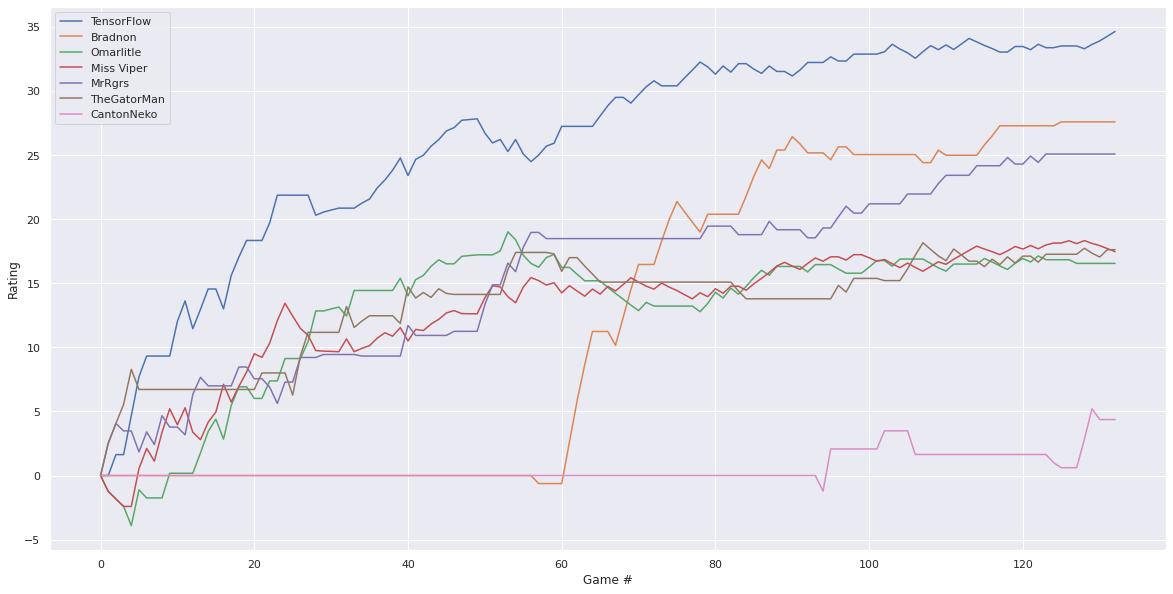

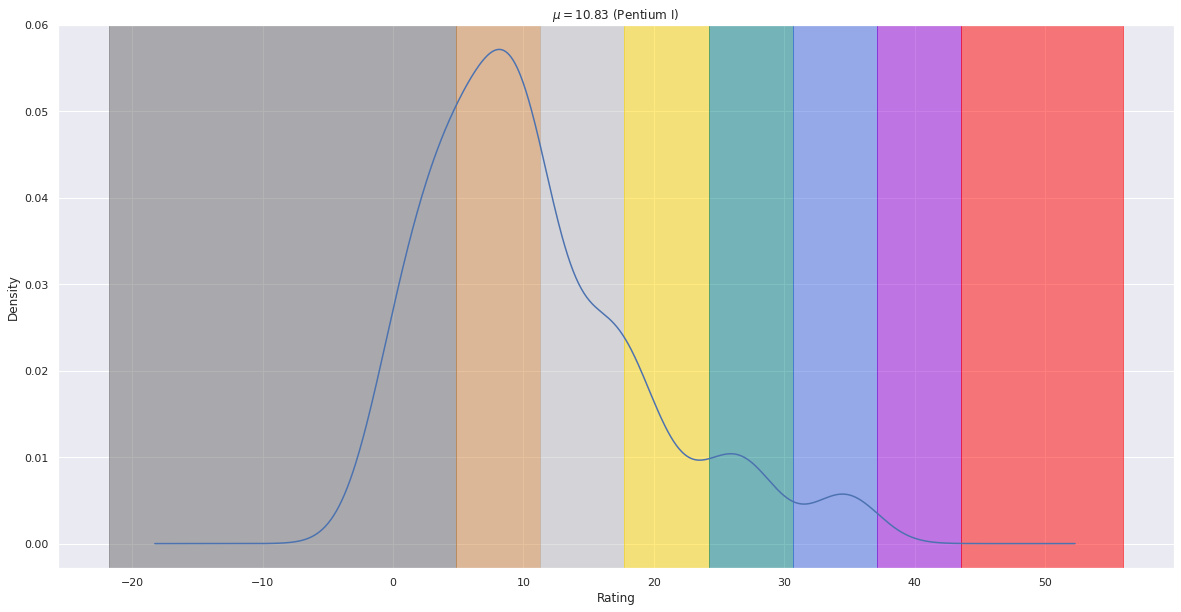

In [24]:
show_draft_stats(matches,num_shown=10,min_games=7)
show_player_wr_by_champ(matches, name='TensorFlow')
name_list = ['TensorFlow','Bradnon','Omarlitle','Miss Viper','MrRgrs','TheGatorMan','CantonNeko']
plot_elo_history(ratings,name_list)
plot_rank_dist(ratings,0.3)

# Synergy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


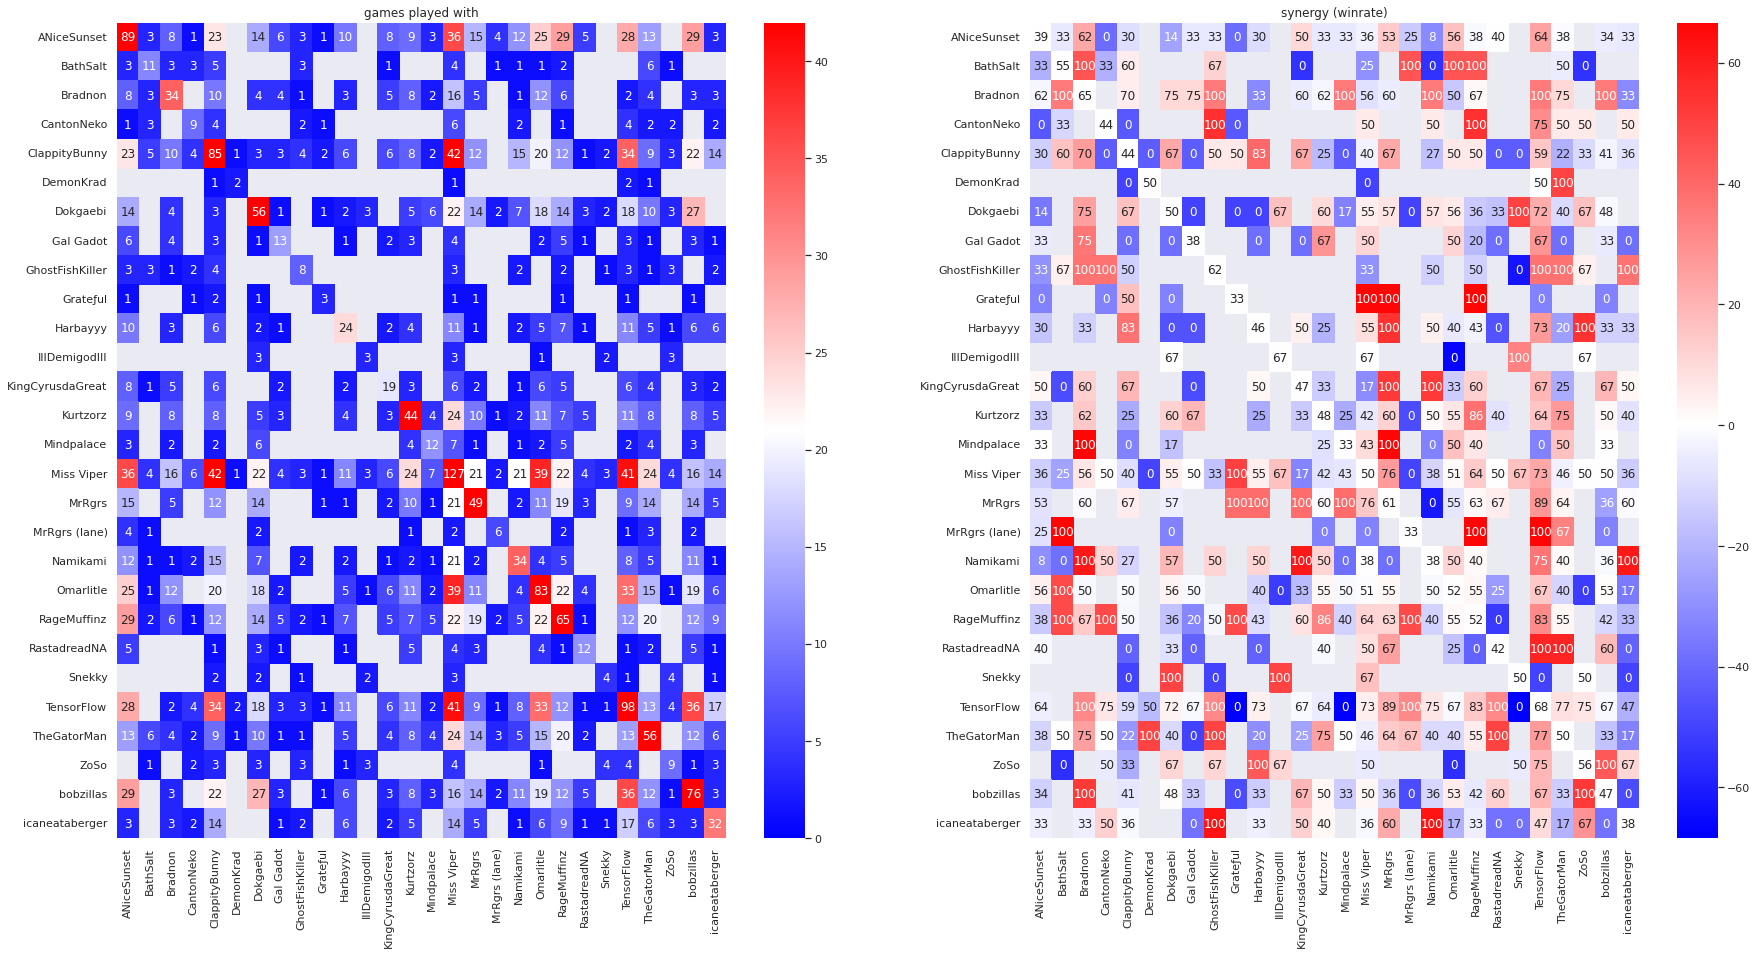

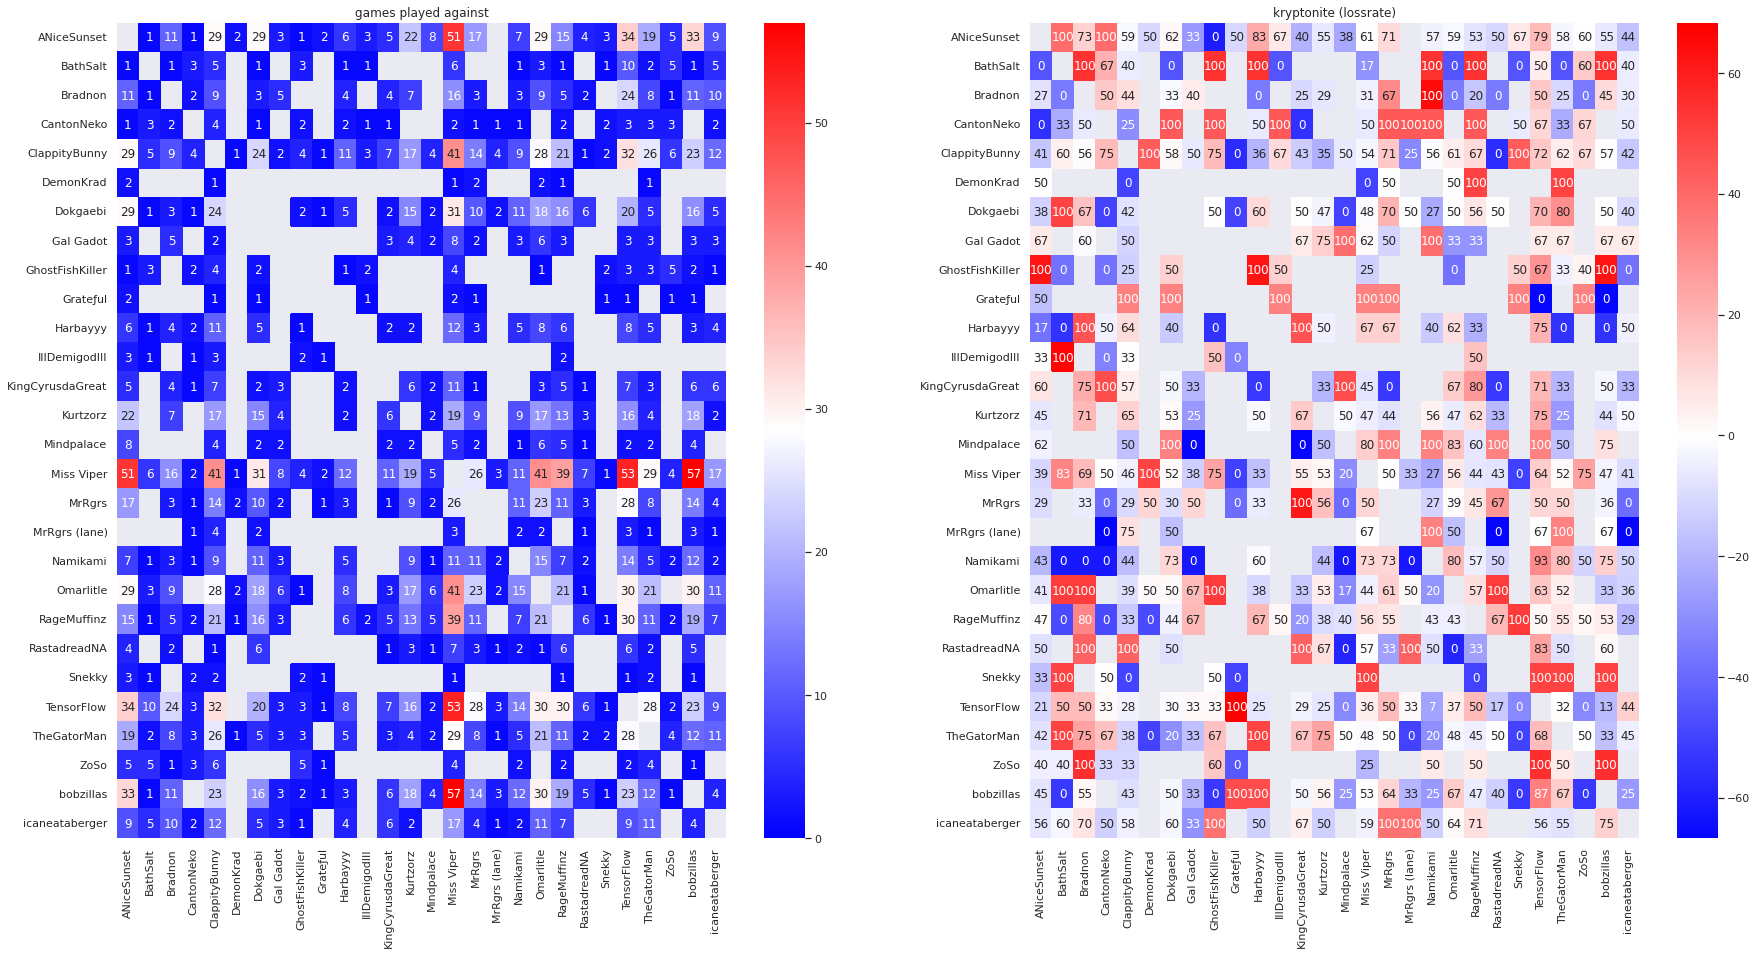

In [22]:
synergy(wins, totals_with)
kryptonite(wins, totals_with, losses, totals_against)

# Matchmaking

In [23]:
display_matchmaking(ratings)